In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import random
import numpy as np

## Creating Functionalities

In [ ]:
import os

#Walkthrough
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/GC"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 6 directories and 0 images in /content/drive/MyDrive/GC.
There are 0 directories and 403 images in /content/drive/MyDrive/GC/cardboard.
There are 0 directories and 501 images in /content/drive/MyDrive/GC/glass.
There are 0 directories and 137 images in /content/drive/MyDrive/GC/trash.
There are 0 directories and 594 images in /content/drive/MyDrive/GC/paper.
There are 0 directories and 410 images in /content/drive/MyDrive/GC/metal.
There are 0 directories and 482 images in /content/drive/MyDrive/GC/plastic.


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/GC",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.


In [ ]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_names = dataset.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[4 0 2 0 0 3 3 3 2 3 1 1 3 3 3 0 2 2 4 3 4 4 1 2 3 3 0 4 2 2 3 4]


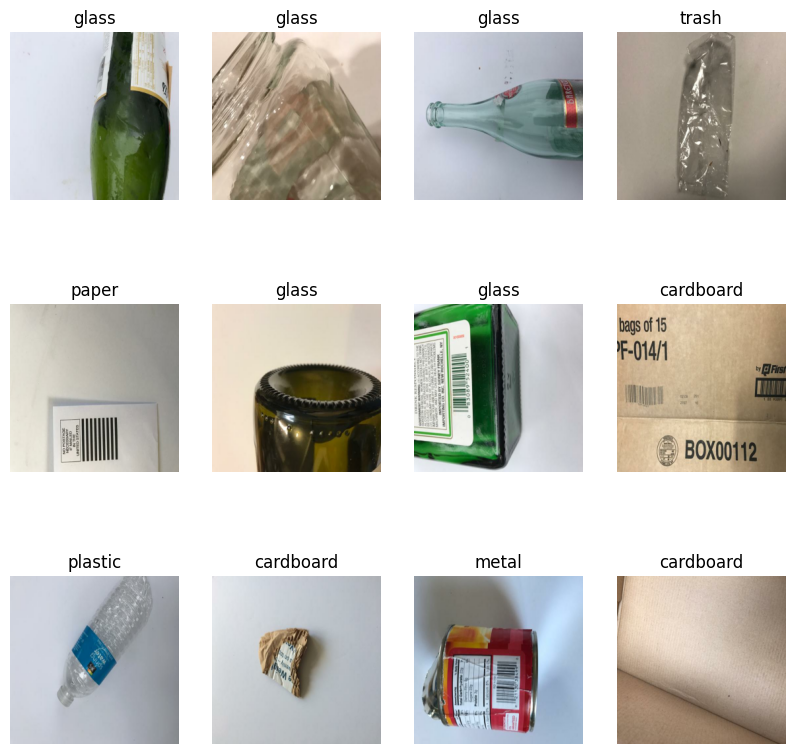

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

79

In [ ]:
train_size = 0.8
len(dataset)*train_size

63.2

In [ ]:
train_ds = dataset.take(64)
len(train_ds)

64

In [ ]:
test_ds = dataset.skip(64)
len(test_ds)

15

In [ ]:
val_size=0.1
len(dataset)*val_size

7.9

In [ ]:
val_ds = test_ds.take(8)
len(val_ds)

8

In [ ]:
test_ds = test_ds.skip(9)
len(test_ds)

6

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

63
7
9


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
63/63 [==============================] - 326s 382ms/step - loss: 1.7361 - accuracy: 0.2277 - val_loss: 1.7424 - val_accuracy: 0.1518
Epoch 2/100
63/63 [==============================] - 17s 275ms/step - loss: 1.6876 - accuracy: 0.2560 - val_loss: 1.5679 - val_accuracy: 0.3214
Epoch 3/100
63/63 [==============================] - 18s 285ms/step - loss: 1.5543 - accuracy: 0.3219 - val_loss: 1.4394 - val_accuracy: 0.4420
Epoch 4/100
63/63 [==============================] - 18s 279ms/step - loss: 1.5194 - accuracy: 0.3502 - val_loss: 1.3450 - val_accuracy: 0.4464
Epoch 5/100
63/63 [==============================] - 17s 274ms/step - loss: 1.4655 - accuracy: 0.3938 - val_loss: 1.5068 - val_accuracy: 0.4018
Epoch 6/100
63/63 [==============================] - 17s 274ms/step - loss: 1.4204 - accuracy: 0.4172 - val_loss: 1.3408 - val_accuracy: 0.4420
Epoch 7/100
63/63 [==============================] - 18s 286ms/step - loss: 1.3891 - accuracy: 0.4578 - val_loss: 1.3550 - val_accuracy

In [ ]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 6s 27ms/step - loss: 0.2972 - accuracy: 0.8958


In [ ]:
scores

[0.2971848249435425, 0.8958333134651184]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 63}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
len(history.history['loss'])

100

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# EPOCHS = 120

ValueError: ignored

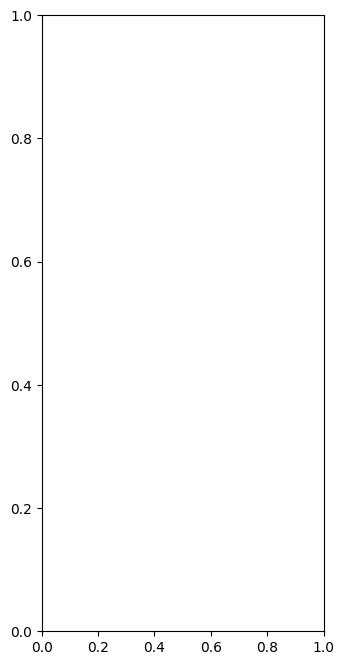

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: trash
1/1 [==============================] - 0s 231ms/step
predicted label: paper


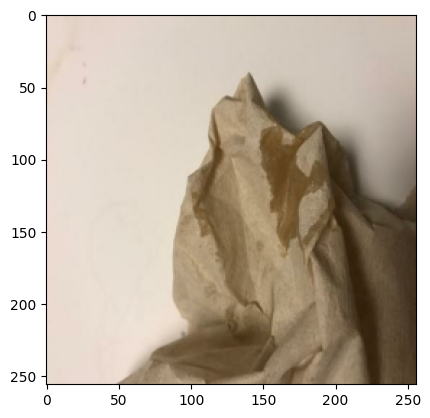

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


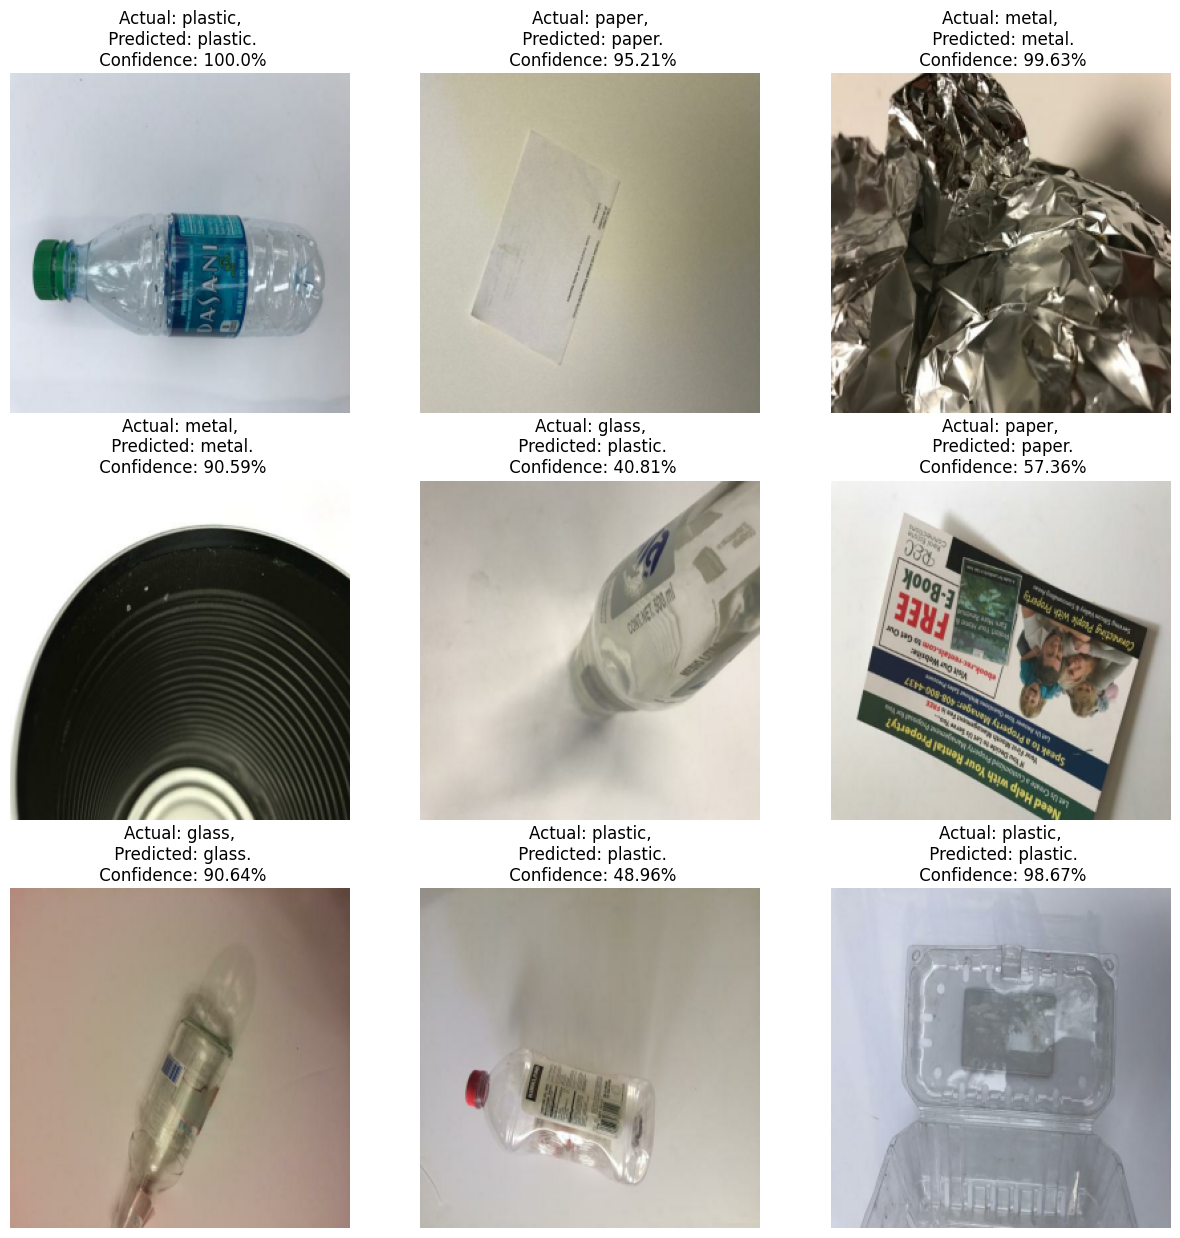

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")

In [ ]:
model.save("/content/wasteV3.h5")